# Credit Card Fraud Detection
- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- credit card fraud detection : 분류 예측
- This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
- 사용할 분류 모델 : 로지스틱 회귀, LightGBM 기반의 모델

#### 이번 데이터 전처리에서 수행할 것
0. 데이터 일차 가공 -> 불필요한 feature drop
1. 왜곡된 데이터 분포도를 변환 -> 데이터 정규화 혹은 데이터 로그 변환
2. 이상치 데이터 제거
3. 이상레이블과 정상레이블의 불균형 -> 오버샘플링(SMOTE)

- 하나하나씩, 각각 얼마나 성능이 증가하는지를 확인해볼것임.

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- V로 시작하는 feature는 의미를 알 수 없으므로 drop
- Time feature는 데이터 생성과 관련한 작업용 속성으로서 큰 의미가 없으므로 drop
- Amount feature는 신용카드 트랙잭션 금액을 의미하고, card_df.info()로 확인해 보면 결측치(Missing Value) 값은 없다. 

- 이번 실습에서는 보다 다양한 데이터 사전 가공을 수행하고, 이에 따른 예측 성능도 함께 비교해보기 위해서 함수를 생성하겠다.
- 먼저, 불필요한 Time 피처만 삭제하는 get_preprocessed_df() 함수부터 생성해보자.

In [3]:
# 먼저, 불필요한 Time 피처만 삭제하는 get_preprocessed_df() 함수부터 생성해보자.
# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

## Seperate Train / Test data

In [4]:
from sklearn.model_selection import train_test_split

# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


학습 dataset과 테스트 dataset의 label 비율을 보니 서로 비슷하게 분할된 것을 알 수 있다.

In [5]:
# 평가 시 사용될 지표를 모은 함수 생성
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## Logistic Regression 

In [6]:
from sklearn.linear_model import LogisticRegression

#lr_clf = LogisticRegression()
#lr_clf.fit(X_train, y_train)
#lr_pred = lr_clf.predict(X_test)
#lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 위 코드로 해도 되나, 앞으로 반복적으로 모델을 변결해 학습/예측/평가할 것이므로 이를 위한 함수를 생성하겠다. 
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train) #학습
    pred = model.predict(ftr_test) #예측
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba) # 위에서 만든 get_clf_eval() 함수를 이용하여 평가 

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9572


## LightGBM

In [7]:
from lightgbm import LGBMClassifier

# 주어진 dataset이 극도로 불균형한 label 분포도를 가지고 있으므로 boost_from_average=Flase로 설정해야 한다.
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


앞의 로지스틱 회귀보다는 높은 수치를 나타냈다. 

## 데이터 분포도 변환 후 모델 학습/예측/평가

- 현재의 데이터는 왜곡된 분포를 가지고 있다. 이렇듯 데이터 분포도가 심하게 왜곡되어 있을 경우에는 데이터를 재가공한 뒤에 모델을 다시 테스트 해보는 것이 필요하다. 
- 로지스틱 회귀는 선형 모델이다. 대부분의 선형 모델은 중요 feature들의 값이 **정규 분포 형태**를 유지하는 것을 선호한다. Amount feature는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. Amount feature의 분포를 확인해보겠다.

<AxesSubplot:xlabel='Amount', ylabel='Density'>

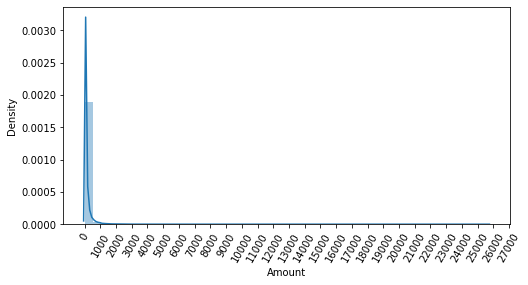

In [8]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

- Amount feature 분포 확인 결과, 데부분의 데이터가 1,000불 이하이며 27,000불까지 사용한 경우가 있어 긴 꼬리의 형태를 가지는 분포 곡선이 나온다. 
- 따라서, Amount feature 를 **표준 정규 분포**로 변환 후, 로지스틱 회귀와 LightGBM 의 성능을 다시 확인해보겠다.
    - 정규 분포로 바꾸기 위해 위 데이터 전처리 과정에서 만들었던 get_processed_df() 함수를 다시 만들것. 사이킷런의 StandardScaler 클래스를 이용해 Amount feature 를 정규분포로 변환하겠다. 

In [9]:
## Data preprocessing : Amount feature 를 정규분포로 변환

from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 정규분포로 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [10]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


- 두 모델 모두 이전과 성능이 크게 개선되지 않았다. 
- 이번에는 StandardScaler가 아닌 로그 변환을 수행해 보겠다. 
    - 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나이다. log 변환으로 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해준다.

In [11]:
## Data preprocessing : Amount feature 를 로그 변환

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


- 두 모델 모두 정밀도와 재현율, ROC-AUC에서 약간의 성능 개선을 확인할 수 있다.

## 이상치 데이터(Outlier) 제거 후 모델 학습/예측/평가

- 이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 이로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다. 
- 따라서 이상치를 찾아내는 방법을 알아보고, 이상치 데이터를 제거한 뒤 다시 모델을 평가해보겠다. 여러 방법들이 있지만 이 중 **IQR(Inter Quantile Range)** 방식을 적용해 보겠다. 
- IQR은 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot) 방식으로 시각화할 수 있다.
-  IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최대값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것이다. 

- 이상치 데이터 IQR을 제거하기 위해 먼저 **어떤 feature의 이상치 데이터를 검출할 것인지 선택이 필요**하다. 매우 많은 feature가 있을 경우 이들 중 결정값(label)과 가장 상관성이 높은 feature들을 위주로 이상치를 검출하는 것이 좋다. 모든 feature들의 이상치를 검출하는 것은 시간이 많이 소모되며, 결정값과 상관성이 높지 않은 feature들의 경우는 이상치를 제거하더라도 크게 성능 향상에 기여하지 않기 때문이다. DataFrame의 corr()을 이용해 각 feature 별로 상관도를 구한 뒤 시본의 heatmap을 통해 시각화해보았다.

<AxesSubplot:>

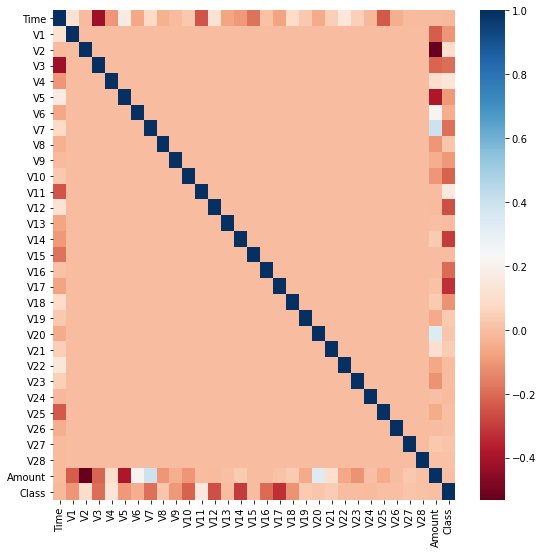

In [12]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')
#cmap을 'RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 
#음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현

- 결정 label인 Class feature와 음의 상관관계가 가장 높은 feature는 V14, V17이다. 
- 이 중 V14만 이상치를 찾아서 제거해보겠다.

In [13]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


- 총 4개의 data가 이상치로 추출되었다. 이제 get_outlier()를 이용해 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가한 후 데이터를 다시 가공해 로지스틱 회귀와 LightGBM 모델에 적용시켜보겠다.

In [14]:
## Data preprocessing : 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

### Before ) Oversampling vs. Undersampling
- 레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문.
- 지도학습에서는, 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요한데, 대표적으로 Oversampling 과 Undersampling 방법이 있음. (Oversampling 방식이 예측 성능상 더 유리한 경우가 많아 주로 사용됨)
    - Undersampling : 많은 레이블을 가진 데이터세트를 적은 레이블을 가진 데이터세트 수준으로 감소시키는 방법. 그러나, 너무 많은 정상 레이블 데이터를 감소시키기 때문에 정상 레이블의 경우, 오히려 제대로 된 학습을 수행할 수 없다는 단점.
    - Oversampling : 적은 레이블을 가진 데이터세트를 많은 레이블을 가진 데이터세트 수준으로 증식시키는 방법. 단, 동일한 데이터를 단순 증식하는 방법은 과적합(Overfitting)이 되기 때문에 의미가 없으므로 원본 데이터의 피처들을 아주 약간만 변경하여 증식함. 대표적으로 SMOTE 방법이 있음.

SMOTE는 imbalanced-learn 패키지의 SMOTE 클래스를 이용해 간단하게 구현이 가능하며, **SMOTE를 적용할 경우엔 반드시 학습 dataset만 오버 샘플링 해야한다.** 검증 dataset이나 테스트 dataset을 오버 샘플링하는 경우 결국은 원본 데이터가 아닌 dataset에서 검증/테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없다.

In [16]:
!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


- 이렇게 정상 레이블과 이상 레이블의 수가 균형 잡힌 학습 dataset 이 새롭게 만들어졌다. 
- 이것을 가지고 모델 학습/예측을 해보자.

In [17]:
# 로지스틱 회귀 모델 학습/예측

lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


- 재현율(recall)이 92.4%로 크게 증가하지만, 정밀도(precision)가 5.4%로 급격하게 저하되는 것을 볼 수 있다. 
- 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class가 1인 데이터를 학습하여 실제 테스트 dataset에서 예측을 **지나치게 Class 1로 적용해 정밀도(precision)가 급격하게 떨어지는 것**이다. 
- 분류 결정 임계값을 조정하여 정밀도(precision)와 재현율(recall) 곡선을 그려보겠다.

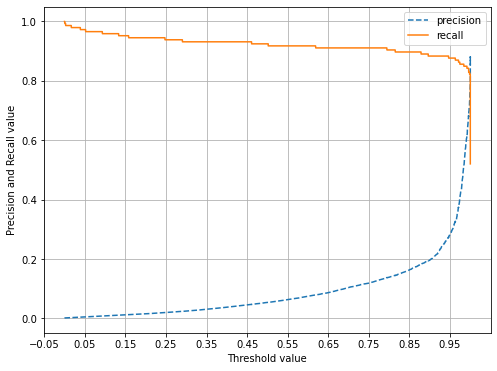

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
   
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
   
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
   
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
   
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

- 임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다. 
- 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심하여 올바른 재현율/정밀도 성능을 얻을 수 없으므로 **로지스틱 회귀 모델의 경우엔 SMOTE를 적용하여 올바른 모델을 생성하지 못했다.** 다음으로 LightGBM 모델을 예측하여 보겠다.

In [19]:
# LightGBM 모델 학습/예측

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


- 재현율이 이상치만 제거했을때보다 약간 상승하였지만 정밀도는 이전보다 낮아진 것을 볼 수 있다. 
- SMOTE를 적용하면 재현율은 높아지지만 정밀도는 낮아지는 것이 일반적인 결과이다. 좋은 SMOTE 패키지일수록 재현율의 증가율은 높이고 정밀도의 감소율은 낮출 수 있도록 효과적으로 데이터를 증식시킨다.